# Transfer Learning

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# 
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

import matplotlib.pyplot as plt

In [ ]:
data_path = '/home/juangomez/Desktop/ML/Cursos/Pepe Cantoral/datasets'
num_train = 45000
batch_size = 64


transform_imagenet = T.Compose([
    T.Resize(224), # Resize the image to 224x224 because the input size for AlexNet is 224x224
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes the image with the ImageNet mean and standard deviation  
])

cifar10_train = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transform_imagenet)
train_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_train)))




cifar10_val = datasets.CIFAR10(
    data_path,
    train= True,
    download=True,
    transform=transform_imagenet)
val_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_train, len(cifar10_val))))


cifar10_test = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform= transform_imagenet)
test_loader = DataLoader(
    cifar10_test,
    batch_size=batch_size,
)


In [19]:
print(num_train, len(cifar10_train))

45000 50000


In [20]:
# this make a generator
data_iter = iter(train_loader)
# get the first batch
images, labels = next(data_iter)
print(images.shape)

torch.Size([64, 3, 224, 224])


## Device

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## Show images

Show the image 0 of the batch 140. Class: 


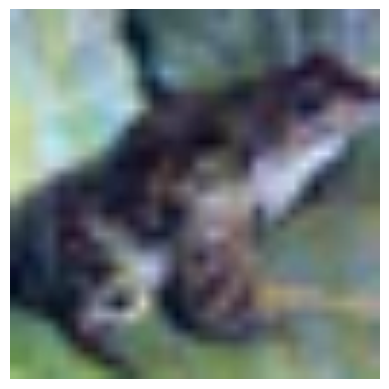

In [22]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

idx= np.random.randint(len(test_loader))
print(f'Show the image 0 of the batch {idx}. Class: ')
image = test_loader.dataset[idx][0]
image = (image- image.min())/(image.max()-image.min())
plot_figure(image)

# Upload Pre-Trained model

In [23]:
model_resnet18 = models.resnet18(pretrained=True)

/home/juangomez/entornoJupyter/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/juangomez/entornoJupyter/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Exploring the model

In [24]:
# w.shape => [out_channels, in_channels, kernel_size, kernel_size]
# w.requires_grad => True if the parameter is trainable
for i, w in enumerate(model_resnet18.parameters()):
    if i <10: 
        print(f'Layer {i}: {w.shape} {w.requires_grad}')
    else:
        break

Layer 0: torch.Size([64, 3, 7, 7]) True
Layer 1: torch.Size([64]) True
Layer 2: torch.Size([64]) True
Layer 3: torch.Size([64, 64, 3, 3]) True
Layer 4: torch.Size([64]) True
Layer 5: torch.Size([64]) True
Layer 6: torch.Size([64, 64, 3, 3]) True
Layer 7: torch.Size([64]) True
Layer 8: torch.Size([64]) True
Layer 9: torch.Size([64, 64, 3, 3]) True


In [25]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Adjust ResNET to our Model

In [26]:
# This is a copy of the model but now is defined as a sequential model
model_aux = nn.Sequential(
    *list(model_resnet18.children())
)
# Delete the last layer
model_aux = nn.Sequential(
    *list(model_resnet18.children())[:-1]
)


# Set not trainable all the parameters of the model
for param in model_aux.parameters():
    param.requires_grad = False

In [27]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [28]:
for i, w in enumerate(model_aux.parameters()):
    if i <10: 
        print(f'Layer {i}: {w.shape} {w.requires_grad}')
    else:
        break

Layer 0: torch.Size([64, 3, 7, 7]) False
Layer 1: torch.Size([64]) False
Layer 2: torch.Size([64]) False
Layer 3: torch.Size([64, 64, 3, 3]) False
Layer 4: torch.Size([64]) False
Layer 5: torch.Size([64]) False
Layer 6: torch.Size([64, 64, 3, 3]) False
Layer 7: torch.Size([64]) False
Layer 8: torch.Size([64]) False
Layer 9: torch.Size([64, 64, 3, 3]) False


# Accuracy


In [1]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device)
            yi = yi.to(device)
            scores = model(xi)
            # Compute the max in each row for each image of the batch
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_total += len(yi)
        return float(num_correct) / num_total

# Training Loop

In [30]:
def train(model, optimizer, epochs=100):
    model = model.to(device = device)
    for epoch in range(epochs):
        model.train()
        for (xi, yi) in train_loader:
            xi = xi.to(device = device, dtype=torch.float32)
            yi = yi.to(device = device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input=scores, target=yi.squeeze())

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        acc = accuracy(model, val_loader)
        if epoch%1 == 0:
            print(f'Epoch {epoch}, Cost: {cost.item()}, accuracy: {acc}')


# New model with modified top layers

In [31]:
lr = 5e-4
epochs = 5
model = nn.Sequential(
    model_aux,
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=10, bias=True)
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas= (0.9, 0.999))
train(model, optimizer, epochs=epochs)

Epoch 0, Cost: 0.49757200479507446, accuracy: 0.7816
Epoch 1, Cost: 0.3904383182525635, accuracy: 0.789
Epoch 2, Cost: 0.6555291414260864, accuracy: 0.802
Epoch 3, Cost: 1.0643106698989868, accuracy: 0.7968
Epoch 4, Cost: 0.876499354839325, accuracy: 0.8076


## Accuracy

In [32]:
acc = accuracy(model, test_loader)
print(f'Accuracy: {acc}')

Accuracy: 0.8058


# Save model

In [2]:
model_path = './models/21-modelTransferLearning.pth'
torch.save(model.state_dict(), model_path)

NameError: name 'torch' is not defined

## Load model

In [38]:
# Este modelo debe ser exactamente igual al modelo que hemos guardado

hidden1 = 1000
hidden2 = 1000
# Instantiate the model
model_cargado = nn.Sequential(
    *list(model.children())
)

In [39]:
model_cargado.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [42]:
acc = accuracy(model_cargado, val_loader)
print(acc)

0.8076
